# 03 — FVNT Flow Estimation Module (Stage 2 / FEM)

**Objective:** Run the **Flow Estimation Module (FEM)** for high-resolution garment deformation (VITON-HD).

### Modern environment fix (Zero-Build)
This notebook uses a pure-Python version of Deformable Conv (DCN) to avoid compilation errors in modern Colab.

### VITON-HD Resolution Fix
FVNT was trained on **256x192** images. For best results with **VITON-HD (1024x768)**, we:
1.  **Downsample** inputs to **256x192** for the model.
2.  **Upsample** the predicted flow field to **1024x768**.
3.  **Rescale** the flow values (multiply by 4) to match the new pixel grid.
4.  **Warp** the original high-resolution garment.

## 0. Environment Setup

In [26]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys, torch, shutil, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import deform_conv2d

PROJECT_ROOT = "/content/drive/MyDrive/virtual_tryon_project"
DATA_ROOT    = f"{PROJECT_ROOT}/data/viton_hd"
TRAIN_ROOT   = f"{DATA_ROOT}/train"
FVNT_DIR     = f"{PROJECT_ROOT}/FVNT"
CHECKPOINT   = f"{FVNT_DIR}/model/stage2_model"

print("✅ Paths configured")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Paths configured


## 1. Clone & Inject Zero-Build DCN

In [27]:
if not os.path.exists(FVNT_DIR):
    !git clone https://github.com/gxl-groups/FVNT.git {FVNT_DIR}

DCN_FOLDER = os.path.join(FVNT_DIR, "Deformable")

if os.path.isdir(DCN_FOLDER):
    shutil.rmtree(DCN_FOLDER)
os.makedirs(DCN_FOLDER, exist_ok=True)

with open(os.path.join(DCN_FOLDER, "__init__.py"), "w") as f:
    f.write("from .modules import DeformConvPack")

modules_py = """
import torch
from torch import nn
from torchvision.ops import deform_conv2d
import math

class DeformConvPack(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding,
                 dilation=1, groups=1, deformable_groups=1, im2col_step=64, bias=True, lr_mult=0.1):
        super(DeformConvPack, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.dilation = (dilation, dilation) if isinstance(dilation, int) else dilation
        self.groups = groups
        self.deformable_groups = deformable_groups
        
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, *self.kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
            
        self.conv_offset = nn.Conv2d(in_channels, 
                                     deformable_groups * 2 * self.kernel_size[0] * self.kernel_size[1],
                                     kernel_size=self.kernel_size, 
                                     stride=self.stride, 
                                     padding=self.padding)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size: n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None: self.bias.data.uniform_(-stdv, stdv)
        self.conv_offset.weight.data.zero_()
        self.conv_offset.bias.data.zero_()

    def forward(self, x):
        offset = self.conv_offset(x)
        return deform_conv2d(x, offset, self.weight, self.bias, 
                             stride=self.stride, padding=self.padding, dilation=self.dilation)
"""

with open(os.path.join(DCN_FOLDER, "modules.py"), "w") as f:
    f.write(modules_py)

if FVNT_DIR not in sys.path: sys.path.insert(0, FVNT_DIR)
from mine.network_stage_2_mine_x2_resflow import Stage_2_generator
print("✅ Zero-Build DCN injected and Stage_2_generator imported.")

✅ Zero-Build DCN injected and Stage_2_generator imported.


## 2. Load Model & Prep Weights

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fem = Stage_2_generator(20).to(device)

# Auto-detect checkpoint path
possible_paths = [
    CHECKPOINT,
    f"{CHECKPOINT}.pth",
    f"{CHECKPOINT}.pt",
    f"{PROJECT_ROOT}/checkpoints/stage2_model",
    f"{PROJECT_ROOT}/checkpoints/stage2_model.pth"
]

actual_ckpt = None
for p in possible_paths:
    if os.path.exists(p):
        actual_ckpt = p
        break

if not actual_ckpt:
    print(f"❌ ERROR: Checkpoint missing! Checked: {possible_paths}")
else:
    print(f"Found checkpoint at: {actual_ckpt}")
    ckpt = torch.load(actual_ckpt, map_location=device)
    fem.load_state_dict(ckpt['G'] if 'G' in ckpt else ckpt)
    fem.eval()
    print("✅ Stage 2 weights loaded successfully.")

Found checkpoint at: /content/drive/MyDrive/virtual_tryon_project/FVNT/model/stage2_model
✅ Stage 2 weights loaded successfully.


## 3. High-Res Warp Logic

In [29]:
def warp_high_res(img_t, low_res_flow):
    """
    Warps a high-res image using a low-res predicted flow field.
    """
    B, _, H_hr, W_hr = img_t.shape
    _, _, H_lr, W_lr = low_res_flow.shape

    # 1. Upsample flow to high-res
    flow_hr = F.interpolate(low_res_flow, size=(H_hr, W_hr), mode='bilinear', align_corners=True)
    
    # 2. Rescale flow values to match high-res grid
    # (e.g., 256 -> 1024 is a 4x increase in pixel space)
    flow_hr[:, 0] = flow_hr[:, 0] * (W_hr / W_lr)
    flow_hr[:, 1] = flow_hr[:, 1] * (H_hr / H_lr)

    # 3. Create Grid
    gx = torch.arange(W_hr, device=device).view(1,-1).repeat(H_hr,1).view(1,1,H_hr,W_hr).expand(B,-1,-1,-1)
    gy = torch.arange(H_hr, device=device).view(-1,1).repeat(1,W_hr).view(1,1,H_hr,W_hr).expand(B,-1,-1,-1)
    grid = torch.cat([gx, gy], 1).float() + flow_hr
    
    # 4. Normalize to [-1, 1] for F.grid_sample
    grid[:, 0] = 2.0 * grid[:, 0] / max(W_hr - 1, 1) - 1.0
    grid[:, 1] = 2.0 * grid[:, 1] / max(H_hr - 1, 1) - 1.0
    
    return F.grid_sample(img_t, grid.permute(0, 2, 3, 1), align_corners=True)

print("✅ High-res warping logic ready.")

✅ High-res warping logic ready.


## 4. Prep Data & Run Inference

In [30]:
# Config
PERSON_ID = "00000_00.jpg" 
H_MODEL, W_MODEL = 256, 192
H_HD, W_HD = 1024, 768

def prep_tensor(path, is_parsing=False):
    img = Image.open(path).resize((W_MODEL, H_MODEL), Image.NEAREST if is_parsing else Image.BILINEAR)
    if is_parsing:
        lbl = np.array(img)
        out = torch.zeros(20, H_MODEL, W_MODEL)
        for i in [4, 5, 6, 7]: out[i] = torch.from_numpy((lbl == i).astype(np.float32))
        return out.unsqueeze(0)
    else:
        return (torch.from_numpy(np.array(img)).permute(2,0,1).float().unsqueeze(0)/127.5-1)

# 1. Load inputs for Model (Downsampled)
t_parse_path = f"{TRAIN_ROOT}/image-parse-v3/{PERSON_ID.replace('.jpg','.png')}"
input_1 = prep_tensor(t_parse_path, is_parsing=True)

s_mask_path = f"{TRAIN_ROOT}/cloth-mask/{PERSON_ID}"
mask_img = Image.open(s_mask_path).resize((W_MODEL, H_MODEL))
input_2 = torch.zeros(1, 20, H_MODEL, W_MODEL)
input_2[0, 5] = torch.from_numpy((np.array(mask_img) >= 128).astype(np.float32))

# 2. Predict Flow
with torch.no_grad():
    flow_list, res_flowlist = fem(input_1.to(device), input_2.to(device))
low_res_flow = flow_list[-1]

# 3. Load High-Res Originals for Visualization
person_hd = Image.open(f"{TRAIN_ROOT}/image/{PERSON_ID}").resize((W_HD, H_HD))
cloth_hd = Image.open(f"{TRAIN_ROOT}/cloth/{PERSON_ID}").resize((W_HD, H_HD))
cloth_hd_t = (torch.from_numpy(np.array(cloth_hd)).permute(2,0,1).float().unsqueeze(0)/127.5-1).to(device)

# 4. Apply High-Res Warp
warped_hd = warp_high_res(cloth_hd_t, low_res_flow)
warped_hd_np = ((warped_hd[0].permute(1,2,0).cpu().numpy()+1)*0.5).clip(0,1)

print(f"✅ Inference complete. Result shape: {warped_hd.shape}")

✅ Inference complete. Result shape: torch.Size([1, 3, 1024, 768])


## 5. Comprehensive Visualization

Showing the input person, garment, masks, and the final high-res warped output.

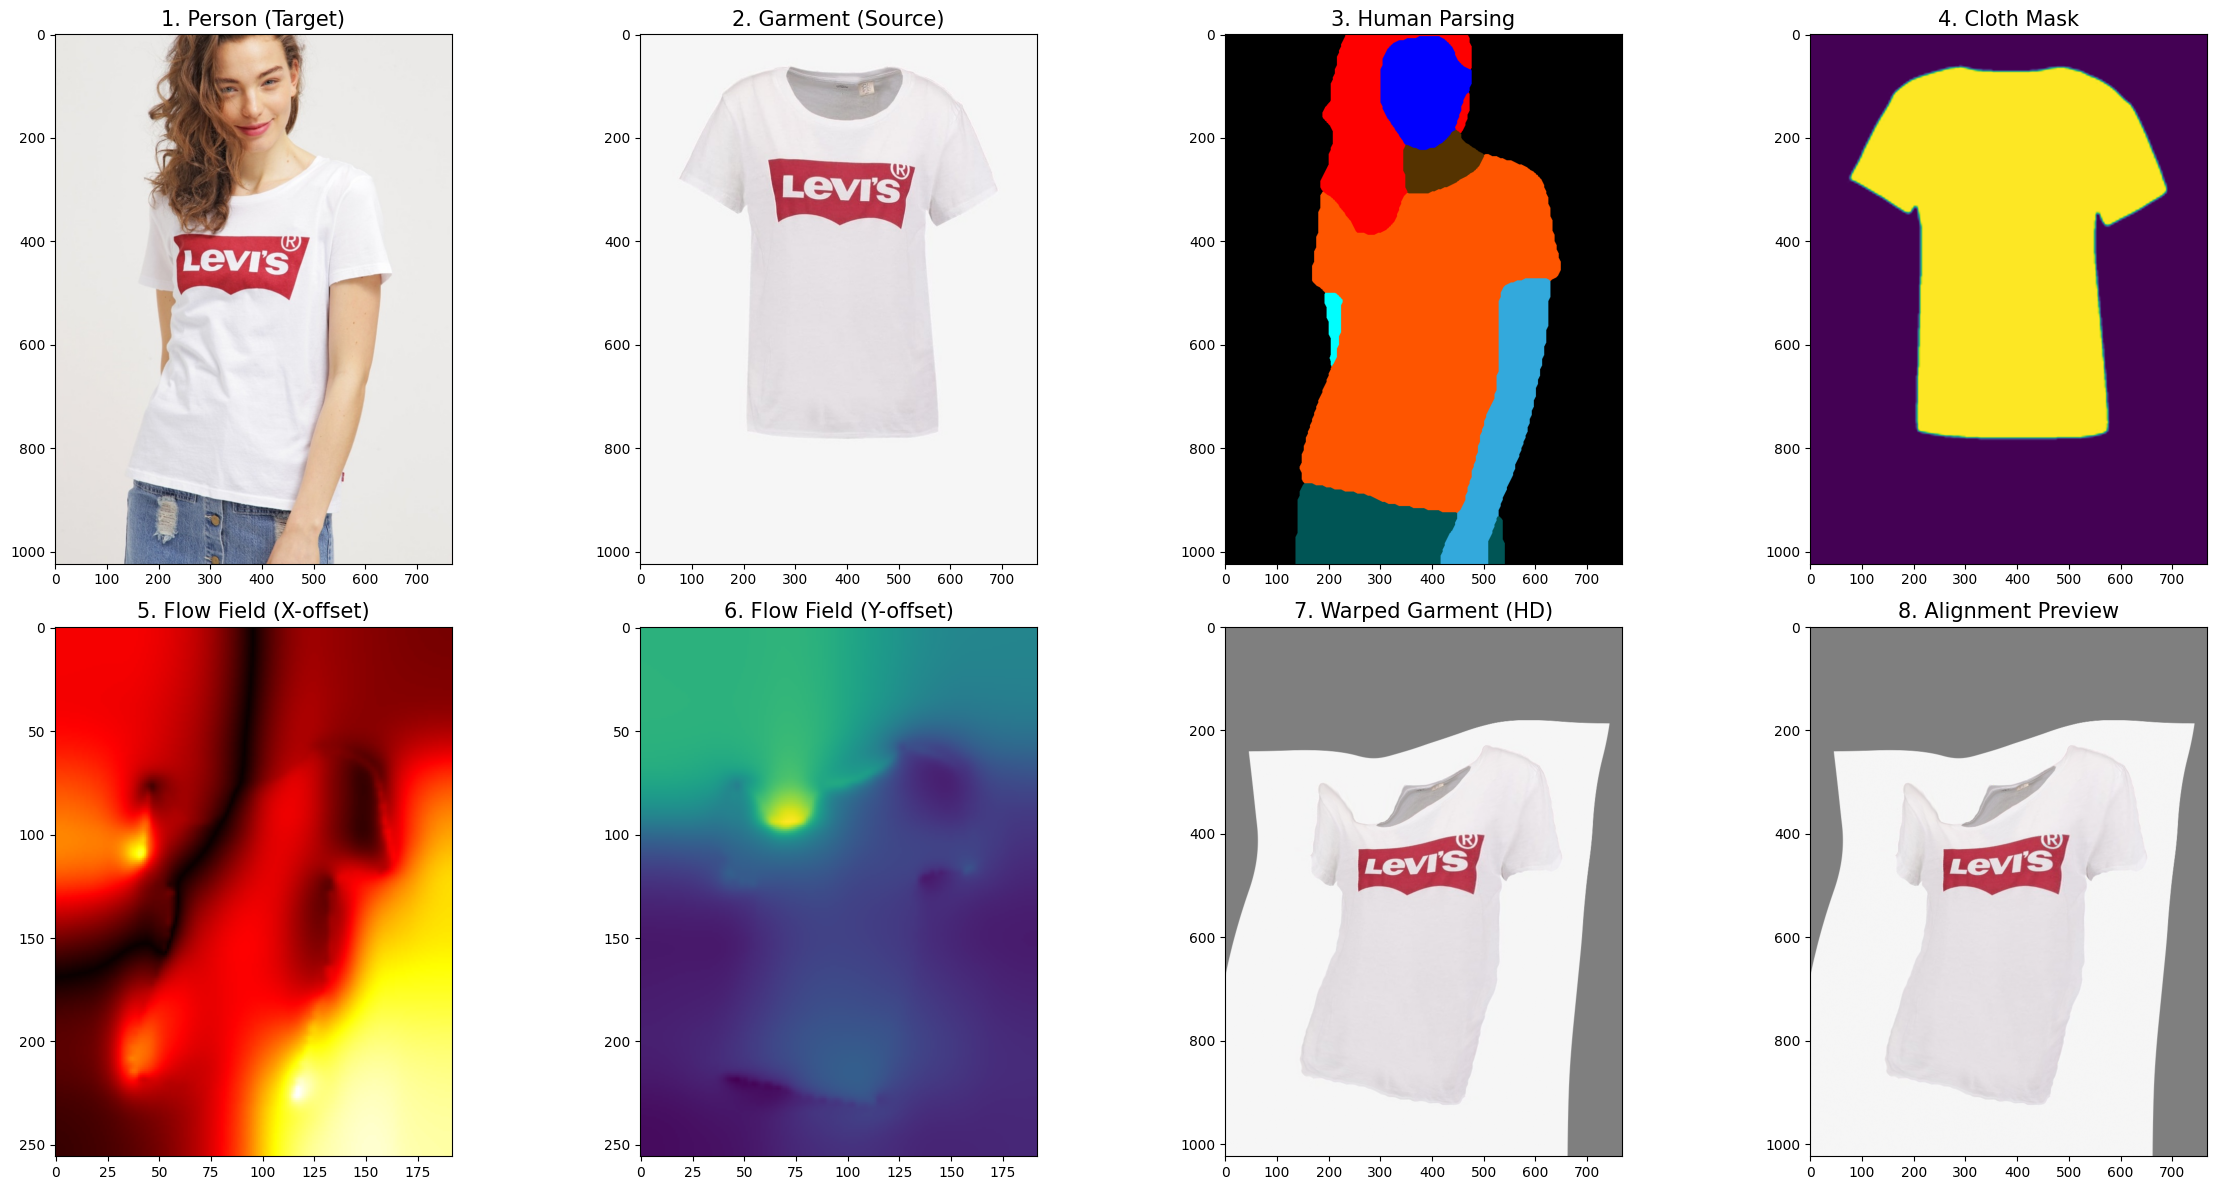

In [31]:
plt.figure(figsize=(24, 12))

# Row 1: Original Inputs
plt.subplot(2, 4, 1); plt.imshow(person_hd); plt.title("1. Person (Target)", fontsize=15)
plt.subplot(2, 4, 2); plt.imshow(cloth_hd); plt.title("2. Garment (Source)", fontsize=15)

# Row 1: Input Analysis (What the model sees)
parse_vis = Image.open(t_parse_path).resize((W_HD, H_HD), Image.NEAREST)
plt.subplot(2, 4, 3); plt.imshow(parse_vis); plt.title("3. Human Parsing", fontsize=15)
plt.subplot(2, 4, 4); plt.imshow(mask_img.resize((W_HD, H_HD))); plt.title("4. Cloth Mask", fontsize=15)

# Row 2: Intermediate results (Flow)
flow_vis = low_res_flow[0].permute(1,2,0).cpu().numpy()
plt.subplot(2, 4, 5); plt.imshow(np.abs(flow_vis[..., 0]), cmap='hot'); plt.title("5. Flow Field (X-offset)", fontsize=15)
plt.subplot(2, 4, 6); plt.imshow(np.abs(flow_vis[..., 1]), cmap='viridis'); plt.title("6. Flow Field (Y-offset)", fontsize=15)

# Row 2: Final Outputs
plt.subplot(2, 4, 7); plt.imshow(warped_hd_np); plt.title("7. Warped Garment (HD)", fontsize=15)

# Quick Try-on Preview (Optional Overlay)
person_np = np.array(person_hd) / 255.0
mask_hd = np.array(mask_img.resize((W_HD, H_HD))) >= 128
try_on_preview = person_np.copy()
# Basic alpha blend to show alignment
try_on_preview = np.where(warped_hd_np < 0.99, warped_hd_np, person_np) 

plt.subplot(2, 4, 8); plt.imshow(try_on_preview); plt.title("8. Alignment Preview", fontsize=15)

plt.tight_layout()
plt.show()

## 6. Save & Exit

In [ ]:
out_dir = f"{PROJECT_ROOT}/outputs"
os.makedirs(out_dir, exist_ok=True)
Image.fromarray((warped_hd_np*255).astype(np.uint8)).save(f"{out_dir}/hd_warped_{PERSON_ID}")
print(f"✅ High-res result saved to {out_dir}/hd_warped_{PERSON_ID}")